In [1]:
import bayesnewton
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.spatial.distance import cdist
from bayes_opt import BayesianOptimization
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import sys, os
sys.path.append('../../Utils')
import model_utils as mutils
%load_ext autoreload
%autoreload 2

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')

lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])

In [3]:
#DATA VARIABLES
SYSTEMS_NUM = 120
TIMESTEPS_NUM = 35295
TRAIN_FRAC = 24  
TEST_STATIONS = 271 - 120

In [4]:
#TRAIN
data_multiple = data.iloc[:, :SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()
stacked = mutils.stack_dataframe(data_multiple, lats, longs)
stacked = stacked[(stacked.latitude < 52.5) & (stacked.latitude > 50.5) & (stacked.longitude > -1) & (stacked.longitude < 1)]
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000

X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])
#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)

#TEST
data_unseen = data.iloc[:, SYSTEMS_NUM:SYSTEMS_NUM+TEST_STATIONS][:TIMESTEPS_NUM].reset_index()
capacities_unseen = uk_pv[uk_pv.ss_id_string.isin(data_unseen.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked_unseen = mutils.stack_dataframe(data_unseen, lats, longs)
stacked_unseen = stacked_unseen[(stacked_unseen.latitude < 52.5) & (stacked_unseen.latitude > 50.5) & (stacked_unseen.longitude > -1) & (stacked_unseen.longitude < 1)]

X_unseen = np.array(stacked_unseen[['epoch', 'longitude', 'latitude']])
Y_unseen = np.array(stacked_unseen[['PV']])
t, R_unseen, Y_unseen = bayesnewton.utils.create_spatiotemporal_grid(X_unseen, Y_unseen)

del data,uk_pv

In [5]:
R_scaler = StandardScaler().fit(R[0])
R_scaled = np.tile(R_scaler.transform(R[0]), (R.shape[0],1, 1)) #renormalise R and project across time
R_scaled_unseen = np.tile(R_scaler.transform(R_unseen[0]), (R_unseen.shape[0],1, 1)) #renormalise R and project across time


In [8]:
def evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t_train, R_train, Y_train, t_test, R_test, Y_test, mini_batch = 1024):
    '''
    Function that calculates the IWD prediction for a single helf out system
    power - power of distance metric
    time_factor - factor that governs the weighted sum between time and space dimension
    
    returns:
    - MAE of the predictor (averages over all systems)
    - prediction for that specific location and timestep
    
    '''
    print('beginning IDW')
    
#     print('get space neighbours')
    nbrs_space = NearestNeighbors(n_neighbors=neighbours_space, algorithm='ball_tree').fit(R_train)
    distances_neighbours_space, idx_neighbours_space = nbrs_space.kneighbors(R_test)
    
    nbrs_time = NearestNeighbors(n_neighbors=neighbours_time, algorithm = 'kd_tree', p=1).fit(t_train)
    distances_neighbours_time, idx_neighbours_time = nbrs_time.kneighbors(t_test)
    
    predictions_list = []
    MAE_list = []
    
    for first in range(0, len(distances_neighbours_time), mini_batch):
        distances_neighbours_time_batch = distances_neighbours_time[first:first+mini_batch]
        idx_neighbours_time_batch = idx_neighbours_time[first:first+mini_batch]
        len_batch = len(distances_neighbours_time_batch)
        distances = np.add.outer(distances_neighbours_space.T, time_factor * distances_neighbours_time_batch.T).swapaxes(0,3)
        weights = (1 / distances)** power
        del distances
        norm_weights = weights / np.sum(weights, axis = (2,3))[:,:, np.newaxis, np.newaxis]
        del weights
        y_neighbours = Y_train[idx_neighbours_time_batch][:,:, idx_neighbours_space].swapaxes(1,2)
        
        prediction = np.sum(norm_weights * y_neighbours, axis = (2,3)) 
        predictions_list.append(prediction)
        del norm_weights

    predictions = np.vstack(predictions_list)
    MAE = (np.nanmean((abs(Y_test - predictions) )))
        
    print('Terminated IDW')
    
    return predictions, MAE



beginning IDW
Terminated IDW


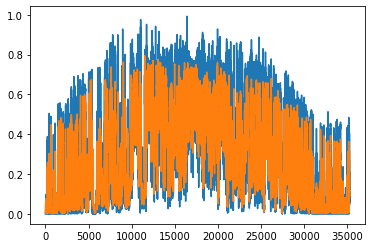

In [10]:
power = 2
time_factor = 1/10
neighbours_space = 20
neighbours_time = 50
predictions, MAE = evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t, R_scaled[0], Y[:,:,0], t, R_scaled_unseen[0], Y_unseen[:,:,0])
plt.plot(Y_unseen[:,5])
plt.plot(predictions[:,5])


In [13]:
def opt_IDW(power, time_factor, n_space, n_time):
    '''
    Wrapper function for bayesian opt of evaluate IDW
    '''
    
    neighbours_space = int(n_space)
    neighbours_time = int(n_time)
    
    predictions, MAE = evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t, R_scaled[0], Y[:,:,0], t, R_scaled_unseen[0], Y_unseen[:,:,0])
    #return the negative value 
    return - MAE



In [14]:
optimiser = BayesianOptimization(
        f = opt_IDW,
        pbounds = {'power' : (0.01, 5), 'time_factor': (0.01, 1), 'n_space': (2, 20), 'n_time': (5, 50)},
        verbose = 2
        )
optimiser.maximize(n_iter = 50, init_points = 5)
print('final result',optimiser.max)

|   iter    |  target   |  n_space  |  n_time   |   power   | time_f... |
-------------------------------------------------------------------------
beginning IDW
Terminated IDW
|  1        | -0.09351  |  5.521    |  22.27    |  0.4714   |  0.8814   |
beginning IDW
Terminated IDW
|  2        | -0.09357  |  12.71    |  5.526    |  0.4605   |  0.265    |
beginning IDW
Terminated IDW
|  3        | -0.08783  |  13.92    |  35.99    |  1.642    |  0.1523   |
beginning IDW
Terminated IDW
|  4        | -0.09238  |  9.513    |  38.04    |  0.8789   |  0.8111   |
beginning IDW
Terminated IDW
|  5        | -0.0856   |  16.67    |  38.99    |  1.896    |  0.9941   |
beginning IDW
Terminated IDW
|  6        | -0.08423  |  19.91    |  36.16    |  3.008    |  0.05135  |
beginning IDW
Terminated IDW
|  7        | -0.085    |  20.0     |  50.0     |  5.0      |  0.01     |
beginning IDW
Terminated IDW
|  8        | -0.085    |  20.0     |  26.02    |  5.0      |  1.0      |
beginning IDW
Terminated IDW

Terminated IDW
|  54       | -0.0843   |  11.63    |  38.0     |  5.0      |  0.01     |
beginning IDW
Terminated IDW
|  55       | -0.085    |  20.0     |  36.84    |  5.0      |  1.0      |
final result {'target': -0.08251199015976204, 'params': {'n_space': 15.625148160076858, 'n_time': 7.655031621578263, 'power': 5.0, 'time_factor': 0.01}}


# RUN WITH OPTIMAL HYPERPARAMS

In [15]:
optimiser_max = {'target': -0.08251199015976204, 'params': {'n_space': 15.625148160076858, 'n_time': 7.655031621578263, 'power': 5.0, 'time_factor': 0.01}}


beginning IDW
Terminated IDW


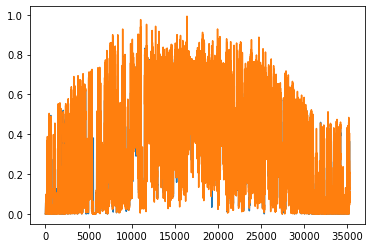

In [18]:
power = optimiser_max['params']['power']
time_factor = optimiser_max['params']['time_factor']
neighbours_space = int(optimiser_max['params']['n_space'])
neighbours_time = int(optimiser_max['params']['n_time'])
predictions, MAE = evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t, R_scaled[0], Y[:,:,0], t, R_scaled_unseen[0], Y_unseen[:,:,0])
plt.plot(predictions[:,5])
plt.plot(Y_unseen[:,5])

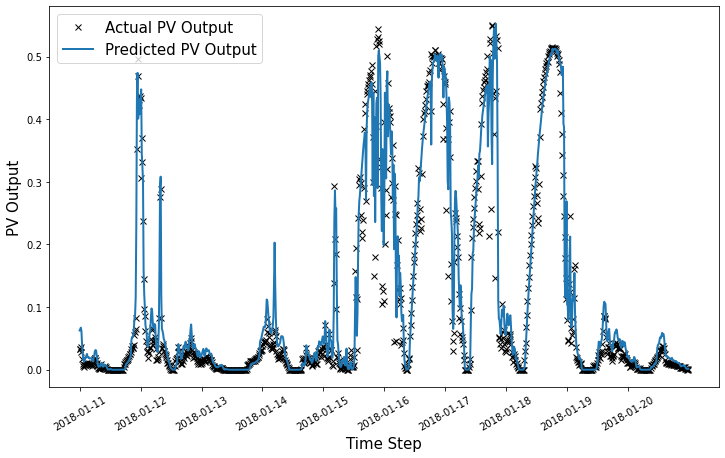

In [44]:
plt.figure(figsize=(12,7))
plt.plot(Y_unseen[1000:2000,4],"xk",  label = 'Actual PV Output')
plt.plot(predictions[1000:2000,4], label = 'Predicted PV Output', c="C0", lw=2, zorder=2)
plt.xlabel('Time Step', fontsize = 15)
plt.ylabel('PV Output', fontsize = 15)
plt.legend(fontsize=15)
plt.xticks(ticks = np.arange(0, 1000, 100), labels = [i[:10] for i in data_multiple[1000:2000].datetime.values[::100]], rotation=30)
plt.savefig(f'../figures/idw_plot.png', dpi=300, bbox_inches='tight')
plt.show();





In [21]:
print(f'THE BENCHMARK MAE IS {MAE}')

THE BENCHMARK MAE IS 0.08251199015976204


# Calculate Metrics

In [22]:
def calc_avg_daily_prod(productions):
    '''
    Given an array of production data for each system, calculates the average daily production for each system in kWh
    '''
    n_days = productions.shape[0] / 96
    avg_daily_prod = productions.sum(axis=0) / (n_days * 12)
    return avg_daily_prod
    
avg_daily_prod_predicted = calc_avg_daily_prod(predictions)
avg_daily_prod_actual = calc_avg_daily_prod(Y_unseen)


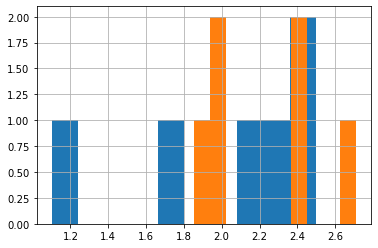

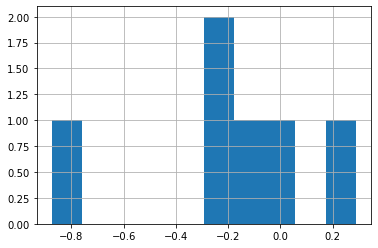

The MAE on the average daily kWh over 368 days is 0.3


In [27]:
pd.Series(avg_daily_prod_actual[:,0]).hist()
pd.Series(avg_daily_prod_predicted).hist()
plt.show()
pd.Series(avg_daily_prod_actual[:,0] - avg_daily_prod_predicted).hist()
plt.show()
MAE_yearly_avg = np.mean(abs(avg_daily_prod_actual[:,0] - avg_daily_prod_predicted))
print(f'The MAE on the average daily kWh over {round(predictions.shape[0] / 96)} days is {round(MAE_yearly_avg, 3)}')


In [25]:
def pred_IDW(power, time_factor, neighbours_space, neighbours_time, t_train, R_train, Y_train, t_test, R_test, mini_batch = 1024):
    '''
    Function that calculates the IWD prediction for a single helf out system
    power - power of distance metric
    time_factor - factor that governs the weighted sum between time and space dimension
    
    returns:
    - MAE of the predictor (averages over all systems)
    - prediction for that specific location and timestep
    
    '''
    print('beginning IDW')
    nbrs_space = NearestNeighbors(n_neighbors=neighbours_space, algorithm='ball_tree').fit(R_train)
    distances_neighbours_space, idx_neighbours_space = nbrs_space.kneighbors(R_test)
    
    nbrs_time = NearestNeighbors(n_neighbors=neighbours_time, algorithm = 'kd_tree', p=1).fit(t_train)
    distances_neighbours_time, idx_neighbours_time = nbrs_time.kneighbors(t_test)
    
    predictions_list = []
    
    for first in range(0, len(distances_neighbours_time), mini_batch):
        distances_neighbours_time_batch = distances_neighbours_time[first:first+mini_batch]
        idx_neighbours_time_batch = idx_neighbours_time[first:first+mini_batch]
        len_batch = len(distances_neighbours_time_batch)
        distances = np.add.outer(distances_neighbours_space.T, time_factor * distances_neighbours_time_batch.T).swapaxes(0,3)
        weights = (1 / distances)** power
        del distances
        norm_weights = weights / np.sum(weights, axis = (2,3))[:,:, np.newaxis, np.newaxis]
        del weights
        y_neighbours = Y_train[idx_neighbours_time_batch][:,:, idx_neighbours_space].swapaxes(1,2)
        
        prediction = np.sum(norm_weights * y_neighbours, axis = (2,3)) 
        predictions_list.append(prediction)
        del norm_weights

    predictions = np.vstack(predictions_list)
        
    print('Terminated IDW')
    
    return predictions



In [30]:
def estimate_production(lat, lon, capacity, historical_error):
    
    
    R_array_2d = np.array([[lat,lon]]) #[:, np.newaxis]
    R_array_2d_scaled = R_scaler.transform(R_array_2d)
    
    
    power = optimiser_max['params']['power']
    time_factor = optimiser_max['params']['time_factor']
    neighbours_space = int(optimiser_max['params']['n_space'])
    neighbours_time = int(optimiser_max['params']['n_time'])
    predictions = pred_IDW(power, time_factor, neighbours_space, neighbours_time, t, R_scaled[0], Y[:,:,0], t, R_array_2d_scaled)
    
    avg_daily_prod_pred = calc_avg_daily_prod(predictions).item()
    avg_daily_prod_pred_kWh = avg_daily_prod_pred * capacity
        
    error = historical_error * capacity
    
    return avg_daily_prod_pred_kWh, error

cap = 0.2
lat = 0
lon = 52
historical_error = MAE_yearly_avg.item()
avg_daily_prod, error = estimate_production(lat, lon, cap, historical_error)
print(f'The Estimated Average daily production in kWh is {round(avg_daily_prod, 3)} ± {round(error, 3)} for a system of capacity {cap} kW')



beginning IDW
Terminated IDW
The Estimated Average daily production in kWh is 0.393 ± 0.06 for a system of capacity 0.2 kW
